## TUTORIAL 05 - Empirical Interpolation Method for non-affine elliptic problems
**_Keywords: empirical interpolation method_**

### 1. Introduction
In this Tutorial, we consider steady heat conduction in a two-dimensional square domain $\Omega = (-1, 1)^2$.
The boundary $\partial\Omega$ is kept at a reference temperature (say, zero). The conductivity coefficient is fixed to 1, while the heat source is characterized by the following expression
$$
g(\boldsymbol{x}; \boldsymbol{\mu}) = \exp\{ -2 (x_0-\mu_0)^2 - 2 (x_1 - \mu_1)^2\} \quad \forall \boldsymbol{x} = (x_0, x_1) \in \Omega.
$$

The parameter vector $\boldsymbol{\mu}$, given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
affects the center of the Gaussian source $g(\boldsymbol{x}; \boldsymbol{\mu})$, which could be located at any point $\Omega$. Thus, the parameter domain is
$$
\mathbb{P}=[-1,1]^2.
$$

In order to obtain a faster evaluation (yet, provably accurate) of the problem we propose to use a certified reduced basis approximation for the problem. In order to preserve the affinity assumption (for the sake of performance) the empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the temperature in the domain $\Omega$.

We will directly provide a weak formulation for this problem
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that</center>

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \left\{ v \in H^1(\Omega(\mu_0)): v|_{\partial\Omega} = 0\right\}
$$
Note that, as in the previous tutorial, the function space is parameter dependent due to the shape variation. 
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u,v;\boldsymbol{\mu}) = \int_{\Omega} \nabla u \cdot \nabla v \ d\boldsymbol{x}$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v;\boldsymbol{\mu}) = \int_\Omega g(\boldsymbol{\mu}) v  \ d\boldsymbol{x}.$$

In [1]:
import sys
sys.path.append("../../MLniCS/")


from mlnics import NN, Losses, Normalization
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

The paramtrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu})$ is trivially affine.
The empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$ to obatin an efficient (approximately affine) expansion of $f(\cdot; \boldsymbol{\mu})$.

In [2]:
@EIM()
class Gaussian(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=subdomains)
        self.f = ParametrizedExpression(
            self, "exp(- 2 * pow(x[0] - mu[0], 2) - 2 * pow(x[1] - mu[1], 2))", mu=(0., 0.),
            element=V.ufl_element())
        # note that we cannot use self.mu in the initialization of self.f, because self.mu has not been initialized yet

    # Return custom problem name
    def name(self):
        return "GaussianEIM"

    # Return the alpha_lower bound.
    def get_stability_factor_lower_bound(self):
        return 1.

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        if term == "a":
            return (1.,)
        elif term == "f":
            return (1.,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx
            return (a0,)
        elif term == "f":
            f = self.f
            f0 = f * v * dx
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 2),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/gaussian.xml")
subdomains = MeshFunction("size_t", mesh, "data/gaussian_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/gaussian_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the Gaussian class

In [5]:
problem = Gaussian(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(-1.0, 1.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = ReducedBasis(problem)
reduction_method.set_Nmax(20, EIM=21)
reduction_method.set_tolerance(1e-4, EIM=1e-3)

Calling FFC just-in-time (JIT) compiler, this may take some time.


### 4.5. Perform the offline phase

In [7]:
reduction_method.initialize_training_set(50, EIM=60)
reduced_problem = reduction_method.offline()

=                      EIM preprocessing phase begins for                      =
=                                    f_12,                                     =
=                                    where                                     =
=       f_12 = exp(- 2 * pow(x[0] - mu_0, 2) - 2 * pow(x[1] - mu_1, 2))        =
=               with id 44056444a8626fa0c94c14ec575e57102a34689e               =

:::::::::::::::::::::::::::::::::::: EIM 0 :::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (0.3556330735924602, -0.4599840536156703)
add to snapshots

:::::::::::::::::::::::::::::::::::: EIM 1 :::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (0.47038804424518976, 0.9243770902348765)
add to snapshots

:::::::::::::::::::::::::::::::::::: EIM 2 :::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (-0.5024937129600839, 0.1523146688356738)
add to snapshots

:::::::::::::::::::::::::::::::::::: EIM 3 :::::

add to snapshots

:::::::::::::::::::::::::::::::::::: EIM 42 ::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (0.8684279958495875, 0.22793191193179196)
add to snapshots

:::::::::::::::::::::::::::::::::::: EIM 43 ::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (0.07126560604991661, 0.17981995270914197)
add to snapshots

:::::::::::::::::::::::::::::::::::: EIM 44 ::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (0.46024405903353927, -0.3761100090407963)
add to snapshots

:::::::::::::::::::::::::::::::::::: EIM 45 ::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (-0.20355787556781624, -0.5803125020497557)
add to snapshots

:::::::::::::::::::::::::::::::::::: EIM 46 ::::::::::::::::::::::::::::::::::::
evaluate parametrized expression at mu = (-0.6276139882393277, 0.8887447799678672)
add to snapshots

:::::::::::::::::::::::::::::::::::: EIM 47 ::::::::::::::::::::::::

find next mu
maximum interpolation error = 0.6961477120995221
maximum interpolation relative error = 0.6962546998794642

:::::::::::::::::::::::::::::::::: EIM N = 7 :::::::::::::::::::::::::::::::::::
solve interpolation for mu = (-0.9506425432173375, -0.8655007370735028)
compute and locate maximum interpolation error
update locations with [-1. -1.]
update basis
update interpolation matrix
interpolation error for current mu = 2.220446049250313e-16
interpolation error on interpolation locations for current mu = 1.1102230246251565e-16
find next mu
maximum interpolation error = 0.6685064589714393
maximum interpolation relative error = 0.6686091986927359

:::::::::::::::::::::::::::::::::: EIM N = 8 :::::::::::::::::::::::::::::::::::
solve interpolation for mu = (0.9806778947934087, -0.5662060312030521)
compute and locate maximum interpolation error
update locations with [ 1.   -0.75]
update basis
update interpolation matrix
interpolation error for current mu = 2.220446049250313e-16
inte


Calling FFC just-in-time (JIT) compiler, this may take some time.
=                     GaussianEIM RB offline phase begins                      =

find initial mu
initial maximum absolute error estimator over training set = 0.3868615264340066
initial maximum relative error estimator over training set = 1.0

#################################### N = 0 #####################################
truth solve for mu = (-0.0876993355669029, 0.13686789773729702)
update basis matrix
build reduced operators
reduced order solve
build operators for error estimation
absolute error for current mu = 9.806232155977301e-16
absolute error estimator for current mu = 1.8995327925655188e-08
find next mu
maximum absolute error estimator over training set = 0.1785470520222935
maximum relative error estimator over training set = 0.46152703182478716

#################################### N = 1 #####################################
truth solve for mu = (0.30621665093079686, -0.4934167949204358)
update basis matrix


maximum relative error estimator over training set = 0.009810073141987438

#################################### N = 15 ####################################
truth solve for mu = (0.6578800584347262, -0.9906090476149059)
update basis matrix
build reduced operators
reduced order solve
build operators for error estimation
absolute error for current mu = 2.9505047339840464e-16
absolute error estimator for current mu = 4.928095845625905e-09
find next mu
maximum absolute error estimator over training set = 0.0034972325641040463
maximum relative error estimator over training set = 0.009040011283470513

#################################### N = 16 ####################################
truth solve for mu = (-0.06737845428738742, -0.5111488159967945)
update basis matrix
build reduced operators
reduced order solve
build operators for error estimation
absolute error for current mu = 9.11552013209516e-16
absolute error estimator for current mu = 5.268356063861754e-09
find next mu
maximum absolute erro

In [10]:
reduction_method.initialize_testing_set(10, EIM=1)
net = NN.RONN(problem, reduction_method)

In [11]:
input_normalization = Normalization.IdentityNormalization()
output_normalization = Normalization.IdentityNormalization()

In [12]:
pdnn_loss = Losses.PDNN_Loss(net, output_normalization)
pinn_loss = Losses.PINN_Loss(net)
prnn_loss = Losses.PRNN_Loss(net, output_normalization, omega=1.)

In [20]:
NN.train(net, pdnn_loss, input_normalization, lr=0.001, epochs=10000)

0 4.3735313481158935e-07 	mean error(validation) = 0.32956210063341246
100 1.9947449585531656e-07 	mean error(validation) = 0.02877487249092313
200 1.4237234215249012e-07 	mean error(validation) = 0.02856744073187264
300 1.3134599968518842e-07 	mean error(validation) = 0.02838635085921606
400 1.253722715415639e-07 	mean error(validation) = 0.028316294465592966
500 3.007523737689262e-07 	mean error(validation) = 0.030522996439243322
600 4.4088439177808246e-07 	mean error(validation) = 0.027304718643773093
700 1.7829774975901507e-07 	mean error(validation) = 0.028074601021711266
800 1.506761287411422e-07 	mean error(validation) = 0.02779208816434852
900 1.1444563134731655e-07 	mean error(validation) = 0.02753581324737365
1000 2.229813737751675e-07 	mean error(validation) = 0.026102785942866056
1100 1.712391525943898e-06 	mean error(validation) = 0.03211062412380018
1200 2.8447654905936493e-07 	mean error(validation) = 0.02924698686814323
1300 8.531589983170558e-07 	mean error(validation)

KeyboardInterrupt: 

### 4.6.1. Perform an online solve

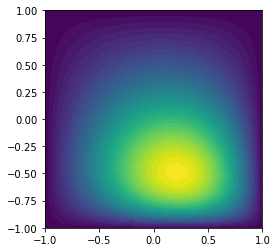

In [23]:
online_mu = (0.3, -1.0)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()
plot(reduced_solution, reduced_problem=reduced_problem)

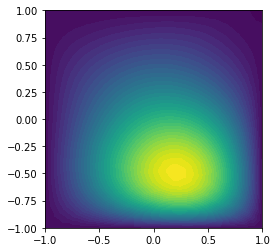

In [24]:
net.eval()
with torch.no_grad():
    online_mu_nn = torch.tensor(online_mu)
    reduced_solution_nn = net.solve(online_mu_nn, input_normalization, output_normalization)
net.train()

plot(reduced_solution_nn, reduced_problem=reduced_problem)

### 4.6.2. Perform an online solve with a lower number of EIM terms

In [ ]:
reduced_solution_11 = reduced_problem.solve(EIM=11)
plot(reduced_solution_11, reduced_problem=reduced_problem)

### 4.6.3. Perform an online solve with an even lower number of EIM terms

In [ ]:
reduced_solution_1 = reduced_problem.solve(EIM=1)
plot(reduced_solution_1, reduced_problem=reduced_problem)

### 4.7.1. Perform an error analysis

In [ ]:
reduction_method.initialize_testing_set(50, EIM=60)
reduction_method.error_analysis(filename="error_analysis")

### 4.7.2. Perform an error analysis with respect to the exact problem

In [ ]:
reduction_method.error_analysis(
    with_respect_to=exact_problem, filename="error_analysis__with_respect_to_exact")

### 4.7.3. Perform an error analysis with respect to the exact problem, but employing a smaller number of EIM terms

In [ ]:
reduction_method.error_analysis(
    with_respect_to=exact_problem, EIM=11, filename="error_analysis__with_respect_to_exact__EIM_11")